In [1]:
import pandas as pd
import geopandas as gpd #geopandas for dataframes with spatial info
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt #for creating plots
import os 
import seaborn as sns #for styling the plots
import statsmodels.formula.api as smf
import warnings
import urllib.request
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

In [3]:
#!curl https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD > current_NYPD_data.csv

In [6]:
data2020 = pd.read_csv('current_NYPD_data.csv')
data2020.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column
0,972326799,81,NaN,09/28/2020,21:27:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,25-44,BLACK,M,1003904,186483,40.678516,-73.929143,"(40.67851591200008, -73.92914304899993)",POINT (-73.92914304899993 40.67851591200008)
1,376304873,52,NaN,09/27/2020,19:13:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,UNKNOWN,BLACK HISPANIC,M,1017928,258050,40.874906,-73.878224,"(40.87490600500007, -73.87822380899996)",POINT (-73.87822380899996 40.87490600500007)
2,299326203,75,NaN,09/21/2020,01:21:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,25-44,BLACK,M,1021234,181211,40.663990,-73.866692,"(40.66399002800006, -73.86669235099998)",POINT (-73.86669235099998 40.66399002800006)
3,674946147,121,NaN,09/15/2020,08:46:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,25-44,BLACK,M,938430,170972,40.635845,-74.165090,"(40.63584491100005, -74.165090337)",POINT (-74.165090337 40.63584491100005)
4,416422620,101,NaN,09/08/2020,13:50:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,18-24,BLACK,M,1049837,157548,40.598875,-73.763823,"(40.59887464700005, -73.76382298499993)",POINT (-73.76382298499993 40.59887464700005)


In [7]:
data2020.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'BORO_NM'], inplace=True)
data2020.shape

(45856, 36)

In [8]:
data2020 = data2020.drop_duplicates(['CMPLNT_NUM'])
data2020.shape

(45856, 36)

In [9]:
(data2020['CMPLNT_FR_DT'].min(), data2020['CMPLNT_FR_DT'].max())

('01/01/1970', '12/31/2019')

In [11]:
data2020=data2020[data2020['PARKS_NM'].isna()]
data2020.shape

(45497, 36)

In [12]:
#!curl https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD > NYPD_data.csv

In [14]:
data = pd.read_csv('NYPD_data.csv')
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,724718389,09/04/2014,17:25:00,09/04/2014,17:35:00,81.0,09/04/2014,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,NaN,40.685041,-73.921777,"(40.685040958, -73.921776995)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F
1,191133903,10/12/2016,07:40:00,10/12/2016,07:45:00,121.0,10/12/2016,109,GRAND LARCENY,417.0,...,U,NaN,40.636991,-74.134093,"(40.63699139, -74.134092508)",PATROL BORO STATEN ISLAND,NaN,45-64,WHITE HISPANIC,F
2,720151206,09/28/2012,13:30:00,09/28/2012,14:00:00,41.0,10/19/2012,109,GRAND LARCENY,413.0,...,M,NaN,40.823876,-73.891863,"(40.823876276, -73.891862968)",PATROL BORO BRONX,NaN,45-64,WHITE HISPANIC,F
3,232242098,03/24/2015,15:45:00,NaN,NaN,46.0,03/24/2015,341,PETIT LARCENY,339.0,...,M,NaN,40.845707,-73.910398,"(40.845707148, -73.910398033)",PATROL BORO BRONX,NaN,<18,WHITE HISPANIC,F
4,708078702,05/20/2017,04:02:00,05/20/2017,04:09:00,109.0,05/20/2017,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.763992,-73.828426,"(40.763991557, -73.828425559)",PATROL BORO QUEENS NORTH,NaN,25-44,BLACK,M


In [15]:
data.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'BORO_NM'], inplace=True)

In [16]:
data = data.drop_duplicates(['CMPLNT_NUM'])

In [17]:
data=data[data['PARKS_NM'].isna()]

In [18]:
(data['CMPLNT_FR_DT'].min(), data['CMPLNT_FR_DT'].max())

('01/01/1948', '12/31/2019')

In [19]:
data["date"] = pd.to_datetime(data["CMPLNT_FR_DT"], format='%m/%d/%Y', errors='coerce')

In [20]:
complaint2019 = data[(data["date"]>=pd.to_datetime('01/01/2019', format='%m/%d/%Y')) & (data["date"]<pd.to_datetime('07/01/2019', format='%m/%d/%Y'))]

In [21]:
complaint2018 = data[(data["date"]>=pd.to_datetime('01/01/2018', format='%m/%d/%Y')) & (data["date"]<pd.to_datetime('07/01/2018', format='%m/%d/%Y'))]
complaint2017 = data[(data["date"]>=pd.to_datetime('01/01/2017', format='%m/%d/%Y')) & (data["date"]<pd.to_datetime('07/01/2017', format='%m/%d/%Y'))]

In [22]:
data2020["date"] = pd.to_datetime(data2020["CMPLNT_FR_DT"], format='%m/%d/%Y', errors='coerce')

In [24]:
complaint2020 = data2020[(data2020["date"]>=pd.to_datetime('01/01/2020', format='%m/%d/%Y')) & (data2020["date"]<pd.to_datetime('07/01/2020', format='%m/%d/%Y'))]
complaint2020.shape

(753, 37)

In [25]:
complaint2017.shape

(224924, 36)

In [26]:
complaint2020 = complaint2020.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2019 = complaint2019.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2018 = complaint2018.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2017 = complaint2017.drop_duplicates(subset="CMPLNT_NUM", keep='last')

In [27]:
CRIME_TYPES = {
    "property crimes": [
        'GRAND LARCENY',
        'PETIT LARCENY',
        'CRIMINAL MISCHIEF & RELATED OF',
        'BURGLARY',
        'ARSON',
        'OFFENSES AGAINST THE PERSON',
        'POSSESSION OF STOLEN PROPERTY',
        'GRAND LARCENY OF MOTOR VEHICLE',
        'OTHER OFFENSES RELATED TO THEF',
        'THEFT-FRAUD',
        'ROBBERY',
        'THEFT OF SERVICES',
        "BURGLAR'S TOOLS",
        'PETIT LARCENY OF MOTOR VEHICLE',
        'JOSTLING'
    ],
    "personal crimes": [
        'ASSAULT 3 & RELATED OFFENSES',
        'HARRASSMENT 2',
        'MURDER & NON-NEGL. MANSLAUGHTER',
        'SEX CRIMES',
        'FELONY ASSAULT',
        'RAPE',
        'KIDNAPPING & RELATED OFFENSES',
        'NYS LAWS-UNCLASSIFIED FELONY',
        'OFFENSES RELATED TO CHILDREN',
        'CHILD ABANDONMENT/NON SUPPORT',
        'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
        'HOMICIDE-NEGLIGENT-VEHICLE',
        'KIDNAPPING',
        'KIDNAPPING AND RELATED OFFENSES',
        'FELONY SEX CRIMES'
    ],
    "drug&alcohol crimes": [
        'DANGEROUS DRUGS',
        'OFF. AGNST PUB ORD SENSBLTY &',
        'ALCOHOLIC BEVERAGE CONTROL LAW',
        'LOITERING FOR DRUG PURPOSES',
        'UNDER THE INFLUENCE OF DRUGS'
    ],
    "traffic crimes": [
        'INTOXICATED & IMPAIRED DRIVING',
        'UNAUTHORIZED USE OF A VEHICLE',
        'UNAUTHORIZED USE OF A VEHICLE',
        'HOMICIDE-NEGLIGENT-VEHICLE',
        'INTOXICATED/IMPAIRED DRIVING',
        'OTHER TRAFFIC INFRACTION'
    ],
    "other crimes": [
        'DANGEROUS WEAPONS',
        'CRIMINAL TRESPASS',
        'FRAUDS',
        'MISCELLANEOUS PENAL LAW',
        'OFFENSES AGAINST PUBLIC ADMINI',
        'FORGERY',
        'OFFENSES INVOLVING FRAUD',
        'FRAUDULENT ACCOSTING',
        'OTHER STATE LAWS (NON PENAL LA',
        'PROSTITUTION & RELATED OFFENSES',
        'GAMBLING',
        'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
        'OFFENSES AGAINST PUBLIC SAFETY',
        'LOITERING',
        'ESCAPE 3',
        'ENDAN WELFARE INCOMP',
        'DISORDERLY CONDUCT',
        'NYS LAWS-UNCLASSIFIED VIOLATION',
        'OTHER STATE LAWS',
        'LOITERING/GAMBLING (CARDS, DIC',
        'UNLAWFUL POSS. WEAP. ON SCHOOL',
        'DISRUPTION OF A RELIGIOUS SERV',
        'ANTICIPATORY OFFENSES',
        'OTHER STATE LAWS (NON PENAL LAW)',
        'LOITERING/DEVIATE SEX',
        'FORTUNE TELLING',
        'ABORTION',
        'OFFENSES AGAINST MARRIAGE UNCL',
        'ADMINISTRATIVE CODE',
        'NEW YORK CITY HEALTH CODE',
        'ADMINISTRATIVE CODES'
    ]
}

In [28]:
complaint2020 = complaint2020.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2019 = complaint2019.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2018 = complaint2018.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2017 = complaint2017.drop_duplicates(subset="CMPLNT_NUM", keep='last')

In [29]:
def reclassify(crime_desc):
    arr = []
    classified = "N/A"
    for crime_code in crime_desc:
        for key in CRIME_TYPES:
            if crime_code in CRIME_TYPES[key]:
                classified = key
        arr.append(classified)
    
    return arr

In [30]:
complaint2020 = complaint2020.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2020["OFNS_DESC"]))))
complaint2019 = complaint2019.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2019["OFNS_DESC"]))))
complaint2018 = complaint2018.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2018["OFNS_DESC"]))))
complaint2017 = complaint2017.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2017["OFNS_DESC"]))))

In [31]:
complaint2019

,index,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date,reclassification
0,4076870,552996231,01/01/2019,16:25:00,NaN,NaN,90.0,01/01/2019,118,DANGEROUS WEAPONS,...,40.701528,-73.943227,"(40.70152764800008, -73.94322736199996)",PATROL BORO BKLYN NORTH,NaN,UNKNOWN,UNKNOWN,E,2019-01-01,other crimes
1,4076872,807279950,01/02/2019,19:50:00,NaN,NaN,43.0,01/02/2019,106,FELONY ASSAULT,...,40.822738,-73.861370,"(40.82273752700007, -73.86137018399995)",PATROL BORO BRONX,NaN,18-24,BLACK,F,2019-01-02,personal crimes
2,4076873,508802958,01/02/2019,22:00:00,01/02/2019,22:10:00,13.0,01/02/2019,106,FELONY ASSAULT,...,40.741944,-73.997223,"(40.741944466000064, -73.99722273099997)",PATROL BORO MAN SOUTH,NaN,65+,WHITE,F,2019-01-02,personal crimes
3,4076876,259858195,01/02/2019,19:45:00,01/03/2019,09:30:00,49.0,01/03/2019,107,BURGLARY,...,40.861760,-73.866618,"(40.861759790000065, -73.86661768999994)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,D,2019-01-02,property crimes
4,4076877,531549247,01/03/2019,15:01:00,NaN,NaN,14.0,01/03/2019,105,ROBBERY,...,40.746851,-73.985724,"(40.74685122900007, -73.98572428799997)",PATROL BORO MAN SOUTH,NaN,45-64,ASIAN / PACIFIC ISLANDER,M,2019-01-03,property crimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217961,4541507,369587676,05/26/2019,04:00:00,05/27/2019,17:00:00,34.0,12/27/2019,341,PETIT LARCENY,...,40.858762,-73.931590,"(40.85876175300007, -73.93159002199997)",PATROL BORO MAN NORTH,NaN,25-44,BLACK HISPANIC,M,2019-05-26,property crimes
217962,4541514,832637862,03/01/2019,09:00:00,NaN,NaN,71.0,12/31/2019,365,ADMINISTRATIVE CODE,...,40.658096,-73.953266,"(40.65809611100008, -73.95326594399995)",PATROL BORO BKLYN SOUTH,NaN,25-44,BLACK,F,2019-03-01,other crimes
217963,4541578,516360537,01/02/2019,10:00:00,01/02/2019,10:05:00,120.0,01/02/2019,578,HARRASSMENT 2,...,40.636068,-74.087252,"(40.63606756200005, -74.08725164599997)",PATROL BORO STATEN ISLAND,NaN,25-44,WHITE,F,2019-01-02,personal crimes
217964,4541581,339599347,01/05/2019,04:10:00,01/05/2019,04:23:00,25.0,01/05/2019,341,PETIT LARCENY,...,40.802422,-73.933822,"(40.802422302000025, -73.93382234599994)",PATROL BORO MAN NORTH,NaN,UNKNOWN,UNKNOWN,D,2019-01-05,property crimes


In [32]:
Type1=['other crimes','personal crimes', 'property crimes', 'drug&alcohol crimes', 'traffic crimes']
complaint2020 = complaint2020[complaint2020['reclassification'].isin(Type1)]
complaint2020

,index,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,...,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,New Georeferenced Column,date,reclassification
0,32,215695380,44,BRONX,06/06/2020,00:10:00,NaN,NaN,COMPLETED,NaN,...,UNKNOWN,E,1004680,239996,40.825394,-73.926183,"(40.825393733000055, -73.92618276999998)",POINT (-73.92618276999998 40.825393733000055),2020-06-06,other crimes
1,34,960386249,13,MANHATTAN,05/31/2020,00:05:00,NaN,NaN,COMPLETED,NaN,...,UNKNOWN,E,988809,206788,40.734269,-73.983551,"(40.734268996000026, -73.98355117399994)",POINT (-73.98355117399994 40.734268996000026),2020-05-31,property crimes
2,36,398930216,1,MANHATTAN,05/18/2020,00:15:00,NaN,NaN,COMPLETED,NaN,...,BLACK,F,982285,201682,40.720255,-74.007090,"(40.72025522300004, -74.00709027999993)",POINT (-74.00709027999993 40.72025522300004),2020-05-18,personal crimes
3,37,237202728,75,BROOKLYN,05/16/2020,17:56:00,NaN,NaN,COMPLETED,NaN,...,UNKNOWN,E,1020007,189768,40.687482,-73.871070,"(40.68748208300008, -73.871069677)",POINT (-73.871069677 40.68748208300008),2020-05-16,other crimes
4,47,493427794,41,BRONX,02/19/2020,02:35:00,NaN,NaN,COMPLETED,NaN,...,UNKNOWN,D,1013086,236614,40.816088,-73.895824,"(40.81608766100004, -73.89582435399994)",POINT (-73.89582435399994 40.81608766100004),2020-02-19,property crimes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,45745,688325456,75,BROOKLYN,04/06/2020,08:00:00,04/07/2020,19:00:00,COMPLETED,NaN,...,BLACK,M,1015160,183234,40.669566,-73.888577,"(40.66956599700006, -73.88857682599996)",POINT (-73.88857682599996 40.66956599700006),2020-04-06,property crimes
749,45831,772794897,45,BRONX,06/29/2020,02:30:00,NaN,NaN,COMPLETED,NaN,...,BLACK,F,1029202,243943,40.836136,-73.837552,"(40.836136344000074, -73.83755237199995)",POINT (-73.83755237199995 40.836136344000074),2020-06-29,personal crimes
750,45856,476922013,73,BROOKLYN,06/28/2020,14:20:00,08/22/2020,08:05:00,COMPLETED,NaN,...,UNKNOWN,D,1006396,182934,40.668769,-73.920170,"(40.66876882300004, -73.92017032899997)",POINT (-73.92017032899997 40.66876882300004),2020-06-28,property crimes
751,45906,157744486,120,STATEN ISLAND,05/05/2020,16:00:00,08/17/2020,10:00:00,COMPLETED,NaN,...,WHITE,M,962774,168898,40.630245,-74.077373,"(40.63024470100004, -74.07737267599998)",POINT (-74.07737267599998 40.63024470100004),2020-05-05,property crimes


In [33]:
complaint2019 = complaint2019[complaint2019['reclassification'].isin(Type1)]
complaint2018 = complaint2018[complaint2018['reclassification'].isin(Type1)]
complaint2017 = complaint2017[complaint2017['reclassification'].isin(Type1)]

In [34]:
selectedNames = [ 'CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'OFNS_DESC','reclassification', 'BORO_NM', 'PARKS_NM', 'Latitude', 'Longitude', 'X_COORD_CD', 'Y_COORD_CD']
data2020re = complaint2020[selectedNames]
data2020re.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,OFNS_DESC,reclassification,BORO_NM,PARKS_NM,Latitude,Longitude,X_COORD_CD,Y_COORD_CD
0,215695380,06/06/2020,00:10:00,DANGEROUS WEAPONS,other crimes,BRONX,NaN,40.825394,-73.926183,1004680,239996
1,960386249,05/31/2020,00:05:00,ARSON,property crimes,MANHATTAN,NaN,40.734269,-73.983551,988809,206788
2,398930216,05/18/2020,00:15:00,RAPE,personal crimes,MANHATTAN,NaN,40.720255,-74.007090,982285,201682
3,237202728,05/16/2020,17:56:00,DANGEROUS WEAPONS,other crimes,BROOKLYN,NaN,40.687482,-73.871070,1020007,189768
4,493427794,02/19/2020,02:35:00,BURGLARY,property crimes,BRONX,NaN,40.816088,-73.895824,1013086,236614


In [38]:
data2019re = complaint2019[selectedNames]
data2018re = complaint2018[selectedNames]
data2017re = complaint2017[selectedNames]
data2020re.shape

(753, 11)

In [39]:
pieCrime2020 = data2020re[['BORO_NM','CMPLNT_NUM','reclassification']].groupby(['reclassification']).count()
pieCrime2020.rename(columns={'CMPLNT_NUM':'N_crime'}, inplace=True)
pieCrime2020

,BORO_NM,N_crime
reclassification,,
drug&alcohol crimes,53,53
other crimes,55,55
personal crimes,156,156
property crimes,477,477
traffic crimes,12,12


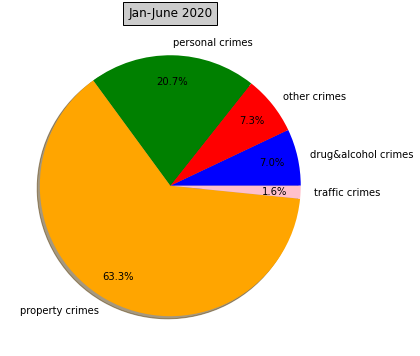

In [43]:
def draw_pie(labels,quants):
    # make a square figure
    plt.figure(1, figsize=(6,6))
    colors  = ["blue","red","green","orange","pink"]  
    # Pie Plot
    # autopct: format of "percent" string;
    plt.pie(quants, colors=colors, labels=labels, autopct='%1.1f%%',pctdistance=0.8, shadow=True)
    plt.title('Jan-June 2020', bbox={'facecolor':'0.8', 'pad':5})
    plt.show()
    plt.savefig("pie.jpg")
    plt.close()

# quants: Number of crimes

# labels: crime types

labels = ['drug&alcohol crimes', 'other crimes', 'personal crimes', 'property crimes' ,'traffic crimes']
quants = [53,55,156,477,12]

draw_pie(labels,quants)

In [44]:
pieCrime2019 = data2019re[['BORO_NM','CMPLNT_NUM','reclassification']].groupby(['reclassification']).count()
pieCrime2019.rename(columns={'CMPLNT_NUM':'N_crime'}, inplace=True)
pieCrime2019

,BORO_NM,N_crime
reclassification,,
drug&alcohol crimes,16666,16666
other crimes,21620,21620
personal crimes,75753,75753
property crimes,100804,100804
traffic crimes,3123,3123


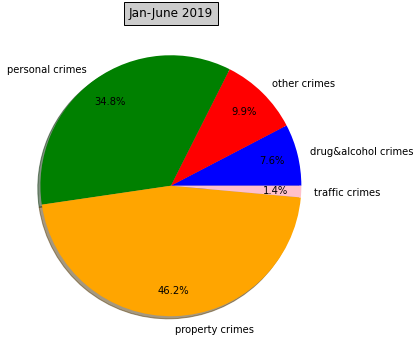

In [46]:
def draw_pie(labels,quants):
    # make a square figure
    plt.figure(1, figsize=(6,6))
    colors  = ["blue","red","green","orange","pink"]  
    # Pie Plot
    # autopct: format of "percent" string;
    plt.pie(quants, colors=colors, labels=labels, autopct='%1.1f%%',pctdistance=0.8, shadow=True)
    plt.title('Jan-June 2019', bbox={'facecolor':'0.8', 'pad':5})
    plt.show()
    plt.savefig("pie.jpg")
    plt.close()

# quants: Number of crimes

# labels: crime types

labels = ['drug&alcohol crimes', 'other crimes', 'personal crimes', 'property crimes' ,'traffic crimes']
quants = [16666,21620,75753,100804,3123]

draw_pie(labels,quants)

In [47]:
pieCrime2018 = data2018re[['BORO_NM','CMPLNT_NUM','reclassification']].groupby(['reclassification']).count()
pieCrime2018.rename(columns={'CMPLNT_NUM':'N_crime'}, inplace=True)
pieCrime2018

,BORO_NM,N_crime
reclassification,,
drug&alcohol crimes,19699,19699
other crimes,21999,21999
personal crimes,75752,75752
property crimes,104900,104900
traffic crimes,3484,3484


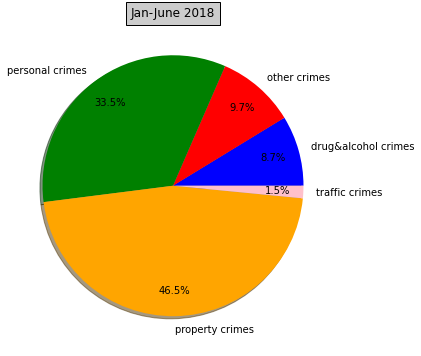

In [49]:
def draw_pie(labels,quants):
    # make a square figure
    plt.figure(1, figsize=(6,6))
    colors  = ["blue","red","green","orange","pink"]  
    # Pie Plot
    # autopct: format of "percent" string;
    plt.pie(quants, colors=colors, labels=labels, autopct='%1.1f%%',pctdistance=0.8, shadow=True)
    plt.title('Jan-June 2018', bbox={'facecolor':'0.8', 'pad':5})
    plt.show()
    plt.savefig("pie.jpg")
    plt.close()

# quants: Number of crimes

# labels: crime types

labels = ['drug&alcohol crimes', 'other crimes', 'personal crimes', 'property crimes' ,'traffic crimes']
quants = [19699,21999,75752,104900,3484]

draw_pie(labels,quants)

In [50]:
pieCrime2017 = data2017re[['BORO_NM','CMPLNT_NUM','reclassification']].groupby(['reclassification']).count()
pieCrime2017.rename(columns={'CMPLNT_NUM':'N_crime'}, inplace=True)
pieCrime2017

,BORO_NM,N_crime
reclassification,,
drug&alcohol crimes,21709,21709
other crimes,22825,22825
personal crimes,71993,71993
property crimes,104663,104663
traffic crimes,3734,3734


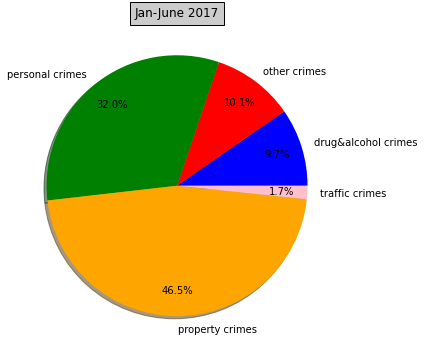

In [51]:
def draw_pie(labels,quants):
    # make a square figure
    plt.figure(1, figsize=(6,6))
    colors  = ["blue","red","green","orange","pink"]  
    # Pie Plot
    # autopct: format of "percent" string;
    plt.pie(quants, colors=colors, labels=labels, autopct='%1.1f%%',pctdistance=0.8, shadow=True)
    plt.title('Jan-June 2017', bbox={'facecolor':'0.8', 'pad':5})
    plt.show()
    plt.savefig("pie.jpg")
    plt.close()

# quants: Number of crimes

# labels: crime types

labels = ['drug&alcohol crimes', 'other crimes', 'personal crimes', 'property crimes' ,'traffic crimes']
quants = [21709,22825,71993,104663,3734]

draw_pie(labels,quants)